In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [5]:
dataset_path = "/kaggle/input/fer2013plus/fer2013plus/fer2013"  


In [6]:
train_dir = "/kaggle/input/fer2013plus/fer2013plus/fer2013/train"
test_dir = "/kaggle/input/fer2013plus/fer2013plus/fer2013/test"


In [7]:
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Class labels:", train_generator.class_indices)


Found 28386 images belonging to 8 classes.
Found 7099 images belonging to 8 classes.
Class labels: {'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happiness': 4, 'neutral': 5, 'sadness': 6, 'surprise': 7}


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("/kaggle/working/emotion_model.keras", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


888/888 ━━━━━━━━━━━━━━━━━━━━ 467s 511ms/step - accuracy: 0.3458 - loss: 1.6284 - val_accuracy: 0.4017 - val_loss: 1.5825
Epoch 2/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 357s 399ms/step - accuracy: 0.3618 - loss: 1.5833 - val_accuracy: 0.3703 - val_loss: 1.5739
Epoch 3/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 385s 431ms/step - accuracy: 0.3700 - loss: 1.5639 - val_accuracy: 0.4048 - val_loss: 1.5536
Epoch 4/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 323s 361ms/step - accuracy: 0.3818 - loss: 1.5561 - val_accuracy: 0.3824 - val_loss: 1.5473
Epoch 5/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 325s 363ms/step - accuracy: 0.3895 - loss: 1.5413 - val_accuracy: 0.4030 - val_loss: 1.5433
Epoch 6/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 324s 363ms/step - accuracy: 0.3999 - loss: 1.5235 - val_accuracy: 0.4074 - val_loss: 1.5005
Epoch 7/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 326s 364ms/step - accuracy: 0.4039 - loss: 1.5182 - val_accuracy: 0.4320 - val_loss: 1.4959
Epoch 8/20
888/888 ━━━━━━━━━━━━━━━━━━━━ 320s 357ms/step - accuracy: 0.4164 - loss: 1.50

In [12]:
loss, accuracy = model.evaluate(val_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.4114 - loss: 1.5974
Test Accuracy: 50.37%


In [15]:
# Save in the new .keras format (recommended)
model.save("/kaggle/working/emotion_model_resnet50.keras")



In [16]:
model.save("/kaggle/working/emotion_model_resnet50.h5", save_format="h5")


In [17]:
import os

os.listdir("/kaggle/working")


['.virtual_documents',
 'emotion_model_resnet50.h5',
 'emotion_model.keras',
 'emotion_model_resnet50.keras']

In [21]:
from IPython.display import FileLink

# For .keras format
FileLink("/kaggle/working/emotion_model_resnet50.keras")

# Or for .h5 (only if you saved in h5 format)
# FileLink("/kaggle/working/emotion_model.h5")


/kaggle/working/emotion_model_resnet50.keras

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


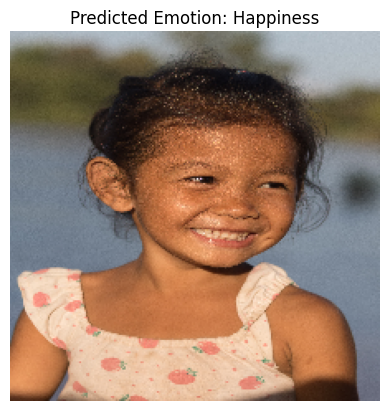

In [22]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Your emotion labels (based on your dataset folder names)
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Load and preprocess the uploaded image
img_path = '/kaggle/input/testing-image-ds/img1.jpg'  #  image name
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Rescale the image like during training
img_array = np.expand_dims(img_array, axis=0)  # Model expects batch of images

# Make prediction
prediction = model.predict(img_array)

# Get the predicted class
predicted_index = np.argmax(prediction)
predicted_label = class_labels[predicted_index]

# Show the image and prediction result
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Hide axes for better visualization
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


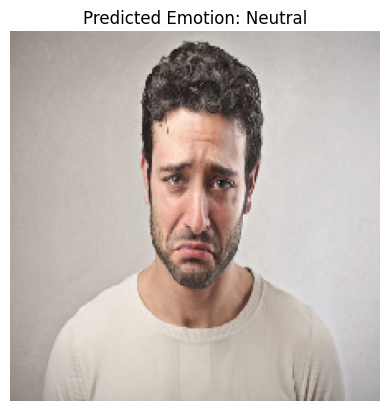

In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Your emotion labels (based on your dataset folder names)
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Load and preprocess the uploaded image
img_path = '/kaggle/input/testing-image-ds/img2.jpg'  #  image name
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Rescale the image like during training
img_array = np.expand_dims(img_array, axis=0)  # Model expects batch of images

# Make prediction
prediction = model.predict(img_array)

# Get the predicted class
predicted_index = np.argmax(prediction)
predicted_label = class_labels[predicted_index]

# Show the image and prediction result
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Hide axes for better visualization
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


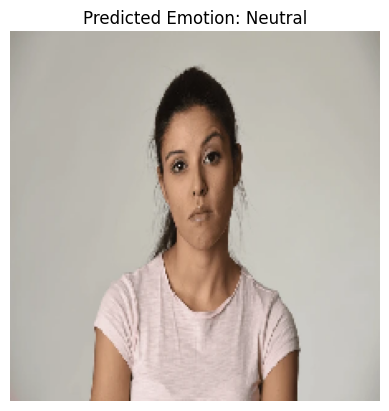

In [25]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Your emotion labels (based on your dataset folder names)
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Load and preprocess the uploaded image
img_path = '/kaggle/input/testing-image-ds/img3.webp'  #  image name
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Rescale the image like during training
img_array = np.expand_dims(img_array, axis=0)  # Model expects batch of images

# Make prediction
prediction = model.predict(img_array)

# Get the predicted class
predicted_index = np.argmax(prediction)
predicted_label = class_labels[predicted_index]

# Show the image and prediction result
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Hide axes for better visualization
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


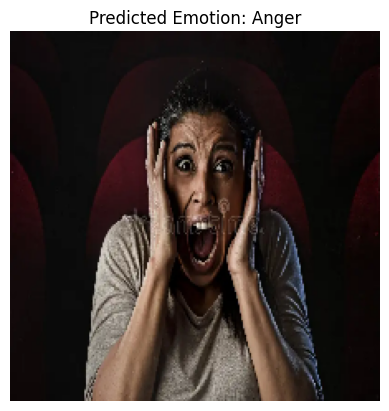

In [33]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Your emotion labels (based on your dataset folder names)
class_labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Load and preprocess the uploaded image
img_path = '/kaggle/input/123456798/img5.webp'  #  image name
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Rescale the image like during training
img_array = np.expand_dims(img_array, axis=0)  # Model expects batch of images

# Make prediction
prediction = model.predict(img_array)

# Get the predicted class
predicted_index = np.argmax(prediction)
predicted_label = class_labels[predicted_index]

# Show the image and prediction result
plt.imshow(img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Hide axes for better visualization
plt.show()